<a href="https://colab.research.google.com/github/alexphil12/Energy-forcasting-UDLA/blob/main/Test_remplissage_entrainement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is created in order to test some filling method that may be used to solved our NaN dataset problem. The method we are going to use may be classified in 3 different types:

*   Statiscal method including: mean filling,median filling and M.A(moving average) filling.
*   Signal processing method:maxi_loc and spectrum_take(for more detail upon thoses please refer to statistics and signal processing method to approximate)
*Deep learning method: here it's only the use of 1D CNN to complete the holes. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import copy as cp
from keras.preprocessing.sequence import TimeseriesGenerator
import statistics 
from scipy.ndimage.filters import uniform_filter1d

In [ ]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten

In [ ]:
import ipywidgets as widgets
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
df = pd.read_csv('/content/df_dev_fin.txt', index_col=0, parse_dates=True,sep=',')
df_test_rempli=pd.read_csv('/content/df_cov_continu_1_1.txt', index_col=0, parse_dates=True,sep=',')
N=len(list(df.iloc[:,3]))
df_train=df.iloc[0:round(N*0.8),:]
df_test=df.iloc[round(N*0.8):N,:]

In [ ]:
mesure=["Fecha","Hora"];
mesure.append("Voltaje_(R)_[V]")	
mesure.append("Voltaje_(S)_[V]")	
mesure.append("Voltaje_(T)_[V]")	
mesure.append("Voltaje_(RS)_[V]")	
mesure.append("Voltaje_(ST)_[V]")	
mesure.append("Voltaje_(TR)_[V]")	
mesure.append("Corriente_R_[A]")	
mesure.append("Corriente_S_[A]")	
mesure.append("Corriente_T_[A]")	
mesure.append("Potencia_R_[VA]")	
mesure.append("Potencia_S_[VA]")	
mesure.append("Potencia_T_[VA]")	
mesure.append("Potencia_R_[W]")	
mesure.append("Potencia_S_[W]")	
mesure.append("Potencia_T_[W]")	
mesure.append("Potencia_R_[VAR]")	
mesure.append("Potencia_S_[VAR]")	
mesure.append("Potencia_T_[VAR]")	
mesure.append("Corriente_N_[A]")	
mesure.append("Frecuencia_[Hz]")	
mesure.append("not_sure_1")	
mesure.append("not_sure_2")	
mesure.append("not_sure_3")	
mesure.append("Potencia_3F_[KVA]")	
mesure.append("Potencia_3F_[W]")	
mesure.append("Potencia_3F_[VAR]")	
mesure.append("Factor de Potencia")

In [ ]:
df_energie = df[[mesure[14]]]
df_energie_rempli=cp.deepcopy(df_test_rempli)

We verify that the dataset we use as a reference doesn't lack any value.

In [ ]:
df_energie_rempli.isnull().sum()

Fecha                 0
Hora                  0
Voltaje_(R)_[V]       0
Voltaje_(S)_[V]       0
Voltaje_(T)_[V]       0
Voltaje_(RS)_[V]      0
Voltaje_(ST)_[V]      0
Voltaje_(TR)_[V]      0
Corriente_R_[A]       0
Corriente_S_[A]       0
Corriente_T_[A]       0
Potencia_R_[VA]       0
Potencia_S_[VA]       0
Potencia_T_[VA]       0
Potencia_R_[W]        0
Potencia_S_[W]        0
Potencia_T_[W]        0
Potencia_R_[VAR]      0
Potencia_S_[VAR]      0
Potencia_T_[VAR]      0
Corriente_N_[A]       0
Frecuencia_[Hz]       0
not_sure_1            0
not_sure_2            0
not_sure_3            0
Potencia_3F_[KVA]     0
Potencia_3F_[W]       0
Potencia_3F_[VAR]     0
Factor de Potencia    0
dtype: int64

In [ ]:
df_plot_energie = df_energie.asfreq(freq='2min')
df_plot_energie_rempli=df_energie_rempli.asfreq(freq='2min')

In [ ]:
df_plot_energie_rempli.isnull().sum()

Fecha                 0
Hora                  0
Voltaje_(R)_[V]       0
Voltaje_(S)_[V]       0
Voltaje_(T)_[V]       0
Voltaje_(RS)_[V]      0
Voltaje_(ST)_[V]      0
Voltaje_(TR)_[V]      0
Corriente_R_[A]       0
Corriente_S_[A]       0
Corriente_T_[A]       0
Potencia_R_[VA]       0
Potencia_S_[VA]       0
Potencia_T_[VA]       0
Potencia_R_[W]        0
Potencia_S_[W]        0
Potencia_T_[W]        0
Potencia_R_[VAR]      0
Potencia_S_[VAR]      0
Potencia_T_[VAR]      0
Corriente_N_[A]       0
Frecuencia_[Hz]       0
not_sure_1            0
not_sure_2            0
not_sure_3            0
Potencia_3F_[KVA]     0
Potencia_3F_[W]       0
Potencia_3F_[VAR]     0
Factor de Potencia    0
dtype: int64

In contrary to the one we may want to fill at the end as shown bellow.

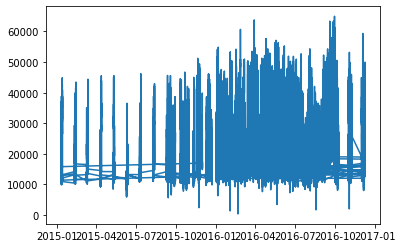

In [ ]:
plt.plot(df_energie[:])

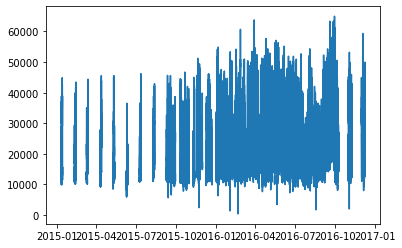

In [ ]:
plt.plot(df_plot_energie[:])

In [ ]:
df_mean=cp.deepcopy(df_energie_rempli)
df_maxi_loc=cp.deepcopy(df_plot_energie_rempli)
df_spectrum_take=cp.deepcopy(df_plot_energie_rempli)
df_AR=cp.deepcopy(df_plot_energie_rempli)


We will only focuse on the Potencia_R_[W] feature, but as the features haves the same holes, we don't lose any generalyti processing this way.

In [ ]:
Num_mes=14

The procedure bellow is the one creating holes, it's taking a random number into a distribution( here a normal of parameters(0,50). if the number is bellow the "limite" value, it when create a hole of the size randomly obtain. otherwise it just past to the next point in the dataframe and reitarate this process.(note that in order to make the lagrange procedure work, at the end of "one holes", the code let a certain number of value untouched to have no problem).

In [ ]:
sigma2=50
mu=0
limite=100
N=4 #this N is the N of Lagrangian interpolation, we interpolate here with 4 points so it with a 3rd degree polynomial
Nombre_lon=len(list(df_energie_rempli.loc[:,mesure[Num_mes]]))
U=cp.deepcopy(df_energie_rempli)
j=10
while(j<Nombre_lon-10):
  H=np.random.normal(loc=mu, scale=sigma2, size=None)
  #H=np.random.exponential(scale=1.0, size=None)
  #H =(np.random.pareto(a, 1000) + 1) * m
  #H=np.random.poisson(5,size=None)
  H=round(abs(H))
  if(H+j<Nombre_lon):
    if(H>limite):
      j+=1
      continue
    else:
      for k in range(H):
        U.iloc[j+k,2:29]=np.nan
      j+=H+round(N/2)
  else:
    j+=1
    continue


In [ ]:
fig = px.line(U, x=U.index, y=U.loc[:,mesure[Num_mes]], title='Plot of Dataframe')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()

In [ ]:
def trace_histo_longueur_donnee(X,nombre_intervalle,dates,mesure):
    H=list(X.loc[dates[0]:dates[1],mesure])
    h1=pd.DataFrame(cp.deepcopy(X[mesure]))
    N=len(H)
    ind=0;
    index_util=[]
    long_nan=[]
    long=[]
    is_nan=[]
    for j in range(N):
        is_nan.append(pd.isna(H[j]))
        if pd.isna(H[j])==False and ind==0:
            index_util.append(j)
            ind=1;
        elif pd.isna(H[j])==True and ind==1:
            index_util.append(j-1)
            ind=0
    index_util.append(N-1)
    long_nan.append(index_util[0])
    
    for j in range(N):
        if is_nan[j]==True:
            is_nan[j]=0
        else:
            is_nan[j]=1
    if(index_util==[]):
      long_nan.append()
    for j in range(0,len(index_util)-1,2):
        long.append(abs(index_util[j]-index_util[j+1]))
    for j in range(0,len(index_util)-2,2):
        long_nan.append(abs(index_util[j+1]-index_util[j+2]))
    fig=plt.figure(figsize=(10,10))
    plt.subplot(2,2,2)
    plt.plot(range(len(H)),H,c="green")
    plt.xlabel("sample")
    plt.ylabel(mesure)
    plt.title("display of"+" "+mesure)
    plt.subplot(2,2,1)   
    plt.hist(long, range = (0, max(long)), bins = np.linspace(0,max(long),nombre_intervalle), color = 'blue',edgecolor = 'black')
    plt.xlabel('length of the interval')
    plt.ylabel('occurency')
    plt.title("Histogram continues data")
    plt.subplot(2,2,3)
    plt.hist(long_nan, range = (0, max(long_nan)), bins = np.linspace(0,max(long_nan),nombre_intervalle), color = 'red',edgecolor = 'black')
    plt.xlabel('length of the NaN')
    plt.ylabel('occurency')
    plt.title("Histogram continues NaN")
    plt.subplot(2,2,4)
    index3=list(h1.index)
    h1=index3.index(dates[0])
    h2=index3.index(dates[1])
    plt.scatter(range(len(is_nan)),is_nan,c="blue",s=0.1)
    plt.xlabel("sample")
    plt.ylabel("nan ou non")
    plt.title("event map")
    fig.show()
    return(0)

In [ ]:
data=pd.read_csv('/content/df_cov_continu_1_1.txt', index_col=0, parse_dates=True,sep=',')
U["index2"] = data["Fecha"] + "-" + data["Hora"]
index3=list(U["index2"])
U.set_index('index2',drop=True,inplace=True);

In this plot, you have the histogram of interval length with NaN and values and the event map showing the location of this intervals. 1 correspond to value intervals, O to NaN

0

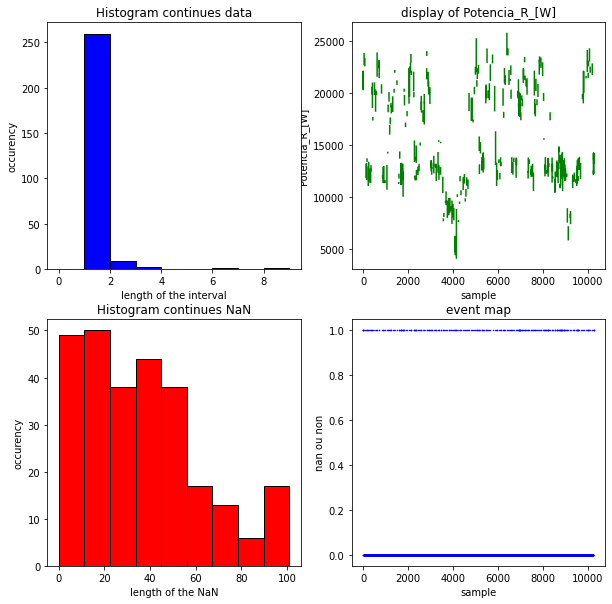

In [ ]:
dates1=[index3[0],index3[-1]]
trace_histo_longueur_donnee(U,10,dates1,mesure[Num_mes])

The first method we use here is the lagrange polynomial interpolation described as follows. Were (ai,bi) are the coodinates we want to interpolate.
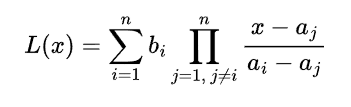

In [ ]:
def polynome_de_lagrange(X,Y,x):
    L_lagrange=[1]*len(X)
    for i in range(len(X)):
        for j in range(len(X)):
            if j!=i:
                L_lagrange[i]=L_lagrange[i]*(x-X[j])/(X[i]-X[j])
    poly_inter=sum([x*y for x,y in zip(L_lagrange,Y)])
    return(poly_inter)

In [ ]:
df=cp.deepcopy(U)
mesure1=14
new_df=cp.deepcopy(df)
H=list(df.iloc[:,mesure1])
Long_data=len(H)
X=list(range(N))
inv=list(reversed(list(range(1,N+1))))
j=0
while j<len(H)-round(N/2)-1:
    if np.isnan(H[j])==True:
        u=cp.deepcopy(j)
        while ((np.isnan(H[j])) and j !=len(H)-round(N/2)-1)==True:
            j+=1
        ecart=abs(u-j)
        X1=list(range(u-round(N/2),u))
        X2=list(range(u+ecart,u+ecart+round(N/2)))
        X=X1+X2
        for k in range(u,j):
          for i in range(2,29):
            Y=[new_df.iloc[x,i] for x in X]
            new_df.iloc[k,i]=polynome_de_lagrange(X, Y, k)
    j+=1
    if(j==len(H)):
        break  

In [ ]:
new_df.isnull().sum()
p=list(new_df.iloc[:,Num_mes])
p2=list(df_energie_rempli.iloc[:,Num_mes])
rmse=np.sqrt(mean_squared_error(p,p2))
mape=mean_absolute_percentage_error(p,p2)
print(rmse)
print(mape)

10372.392633487441
2.417700975699501


In [ ]:
plot_final=cp.deepcopy(new_df.loc[:,mesure[Num_mes]])
plot_final=plot_final.to_frame()
plot_final.insert(1,"power",np.array(df_energie_rempli.loc[:,mesure[Num_mes]]))

0

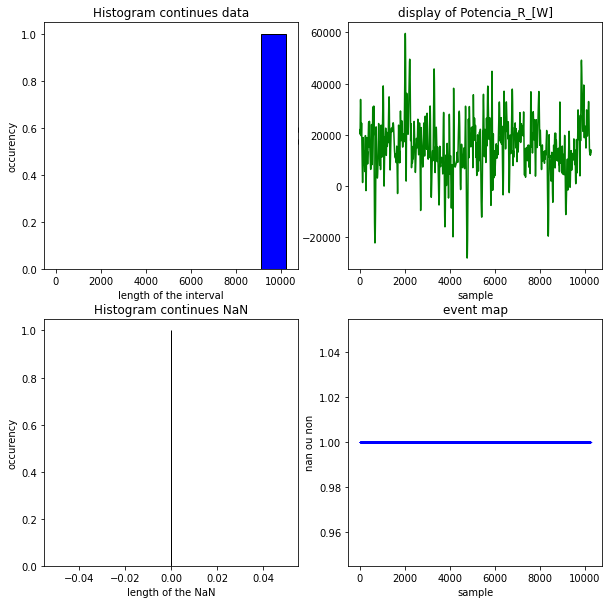

In [ ]:
trace_histo_longueur_donnee(new_df,10,dates1,mesure[Num_mes])


In [ ]:
fig = px.line(plot_final, x=plot_final.index, y=plot_final.loc[:,mesure[Num_mes]:"power"].columns, title='Plot of correction')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()

On this part, we just fill the holes with the mean value of the signal.

In [ ]:
new_df_mean=cp.deepcopy(U)
import statistics
moyenne=[]
for j in range(2,29):
  moyenne.append(statistics.mean(new_df.loc[:,mesure[j]])) 
for k in range(Long_data):
  if np.isnan(new_df_mean.iloc[k,3])==True:
    for j in range(2,29):
      new_df_mean.iloc[k,j]=moyenne[j-2]


0

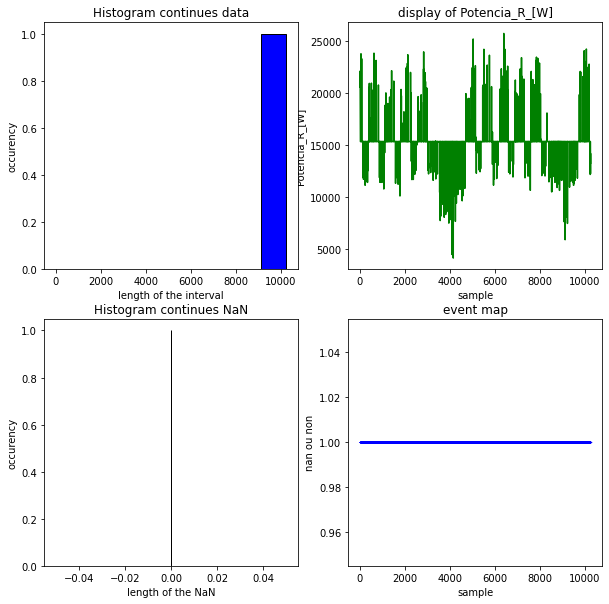

In [ ]:
trace_histo_longueur_donnee(new_df_mean,10,dates1,mesure[Num_mes])

In [ ]:
new_df_mean.isnull().sum()
p=list(new_df_mean.iloc[:,Num_mes])
p2=list(df_energie_rempli.iloc[:,Num_mes])
rmse=np.sqrt(mean_squared_error(p,p2))
mape=mean_absolute_percentage_error(p,p2)
print(rmse)
print(mape)

4830.478104469772
0.2731332872478903


In [ ]:
plot_final=cp.deepcopy(new_df_mean.loc[:,mesure[Num_mes]])
plot_final=plot_final.to_frame()
plot_final.insert(1,"power",np.array(df_energie_rempli.loc[:,mesure[Num_mes]]))

In [ ]:
fig = px.line(plot_final, x=plot_final.index, y=plot_final.loc[:,mesure[Num_mes]:"power"].columns, title='Plot of correction')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()

Same thing here with the median value.

In [ ]:
new_df_median=cp.deepcopy(U)
import statistics
med=[]
for j in range(2,29):
  med.append(statistics.median(new_df.loc[:,mesure[j]])) 
for k in range(Long_data):
  if np.isnan(new_df_median.iloc[k,3])==True:
    for j in range(2,29):
      new_df_median.iloc[k,j]=med[j-2]

0

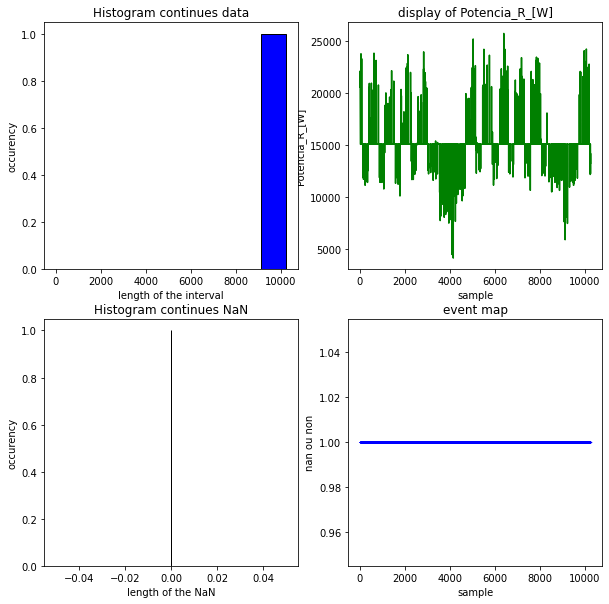

In [ ]:
trace_histo_longueur_donnee(new_df_median,10,dates1,mesure[Num_mes])

In [ ]:
new_df_median.isnull().sum()
p=list(new_df_median.iloc[:,Num_mes])
p2=list(df_energie_rempli.iloc[:,Num_mes])
rmse=np.sqrt(mean_squared_error(p,p2))
mape=mean_absolute_percentage_error(p,p2)
print(rmse)
print(mape)

4865.4005173819205
0.27705015574223124


In [ ]:
plot_final=cp.deepcopy(new_df_median.loc[:,mesure[Num_mes]])
plot_final=plot_final.to_frame()
plot_final.insert(1,"power",np.array(df_energie_rempli.loc[:,mesure[Num_mes]]))

In [ ]:
fig = px.line(plot_final, x=plot_final.index, y=plot_final.loc[:,mesure[Num_mes]:"power"].columns, title='Plot of correction')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()

On this part, we are using a trained CNN to fill the holes.(it uses 10 window_length signal to do the prediction and is trained on another dataset).

In [ ]:
df_2 = pd.read_csv('/content/df_cov_continu_1_0.txt', index_col=0, parse_dates=True,sep=',')
N2=len(list(df_2.iloc[:,3]))
df_train=df_2.iloc[0:round(N2*0.8),:]
df_test=df_2.iloc[round(N2*0.8):N2,:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
RSG_train = df_train[mesure[Num_mes]].values
RSG_test = df_test[mesure[Num_mes]].values
scaler.fit(RSG_train.reshape(-1,1))

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(RSG_train.reshape(-1,1))
scaled_test = scaler.transform(RSG_test.reshape(-1,1))

In [ ]:
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps
		if end_ix > len(sequence)-1:
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
n_steps=10
n_features=1
X,y=split_sequence(scaled_train,n_steps)
X_test,y_test=split_sequence(scaled_test,n_steps)

In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
X = X.reshape(X.shape[0], X.shape[1], n_features)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],n_features)

In [ ]:
model.fit(X, y, epochs=100, verbose=1,batch_size=100,validation_data=(X_test,y_test))

Epoch 1/100
52/52 [==============================] - 1s 8ms/step - loss: 0.0092 - val_loss: 0.0103
Epoch 2/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0025 - val_loss: 0.0092
Epoch 3/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0085
Epoch 4/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0083
Epoch 5/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0084
Epoch 6/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0081
Epoch 7/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0022 - val_loss: 0.0081
Epoch 8/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 9/100
52/52 [==============================] - 0s 5ms/step - loss: 0.0021 - val_loss: 0.0080
Epoch 10/100
52/52 [==============================] - 0s 4ms/step - loss: 0.0020 - val_loss: 0.0080
Epoch 11/

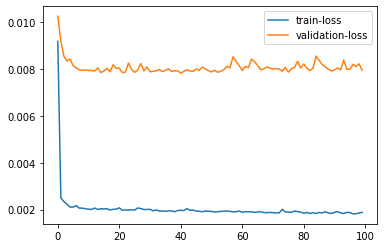

In [ ]:
loss_per_epoch = model.history.history['loss']
loss_vall=model.history.history['val_loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch,label="train-loss")
plt.plot(range(len(loss_vall)),loss_vall,label="validation-loss")
plt.legend()

In [ ]:
new_df_cnn=cp.deepcopy(U)
batch_predict=scaler.transform(np.array(new_df_cnn.iloc[:,Num_mes]).reshape(-1,1))
for j in range(9,Nombre_lon):
  if np.isnan(new_df_cnn.iloc[j,Num_mes])==True:
    current_batch = batch_predict[j-9:j+1].reshape((1, n_steps, n_features))
    predict=model.predict(current_batch)
    batch_predict[j]=predict
    new_df_cnn.iloc[j,Num_mes]=float(scaler.inverse_transform(predict))

0

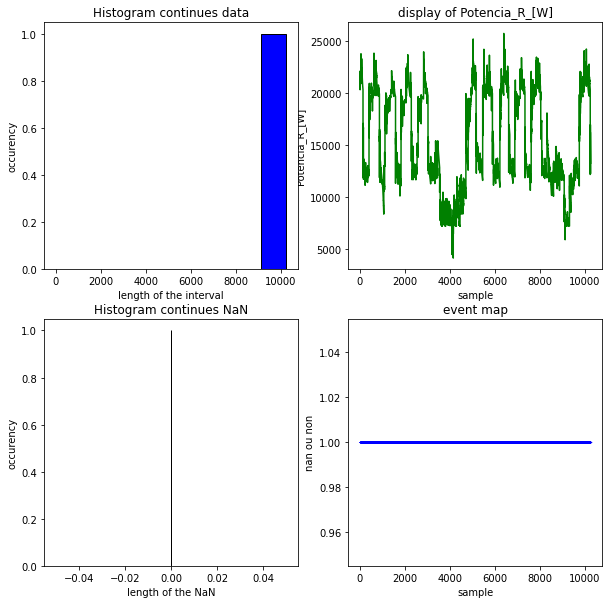

In [ ]:
trace_histo_longueur_donnee(new_df_cnn,10,dates1,mesure[Num_mes])

In [ ]:
new_df_cnn.isnull().sum()
p=list(new_df_cnn.iloc[:,Num_mes])
p2=list(df_energie_rempli.iloc[:,Num_mes])
rmse=np.sqrt(mean_squared_error(p,p2))
mape=mean_absolute_percentage_error(p,p2)
print(rmse)
print(mape)

2398.6943574343773
0.11576990305291456


In [ ]:
plot_final=cp.deepcopy(new_df_cnn.loc[:,mesure[Num_mes]])
plot_final=plot_final.to_frame()
plot_final.insert(1,"power",np.array(df_energie_rempli.loc[:,mesure[Num_mes]]))

In [ ]:
fig = px.line(plot_final, x=plot_final.index, y=plot_final.loc[:,mesure[Num_mes]:"power"].columns, title='Plot of correction')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()

In this part, we use the maxi_loc and spectrum takes methods.

In [ ]:
def maxi_loc(X,deg):
  N=len(X)
  Max_loc=[]
  for k in range(1,N-1):
    if np.abs(X[k])>= deg*np.abs(X[k-1]) and np.abs(X[k])>=deg*np.abs(X[k+1]):
      Max_loc.append(k)
      Max_loc.append(2*X[k])
  return(Max_loc)

In [ ]:
def spectrum_take(X,freq_max):
  N=len(X)
  spectre=[0]*len(X)
  h=30/freq_max
  k1=round(len(X)/h)
  spectre[0:k1]=X[0:k1]
  spectre[len(X)-k1:len(X)]
  return(spectre)

In [ ]:
def cons_sig(sigma2,deg,sig,n):
  sig2=uniform_filter1d(sig,n)
  spectre=np.fft.fft(sig2)
  Max_loc=maxi_loc(spectre,deg)
  new_spectre=np.zeros(len(spectre))
  mean=statistics.mean(sig)
  for k in range(round(len(Max_loc)/2)):
    new_spectre[Max_loc[2*k]]=Max_loc[2*k+1]
  periodic=np.real(np.fft.ifft(new_spectre))
  noise = np.random.normal(0,sigma2,len(sig2))
  sig_recons=periodic+noise
  sig_recons=sig_recons+[mean]*len(sig_recons)
  return(sig_recons)

In [ ]:
def cons_sig_2(sigma2,freq_max,sig,n):
  sig2=uniform_filter1d(sig,n)
  spectre=np.fft.fft(sig2)
  spectrum_new=spectrum_take(spectre,freq_max)
  mean=statistics.mean(sig)
  periodic=2*np.real(np.fft.ifft(spectrum_new))-[mean]*len(spectrum_new)
  noise = np.random.normal(0,sigma2,len(sig2))
  sig_recons=periodic+noise
  return(sig_recons)

In [ ]:
df_6 = pd.read_csv('/content/df_cov_continu_1_0.txt', index_col=0, parse_dates=True,sep=',')
N6=len(list(df_6.iloc[:,3]))
df_train6=df_6.iloc[0:round(N6*0.8),:]# to apply the method, we reconstrud a full week and then copy it the number of time necessary to have
df_test6=df_6.iloc[round(N6*0.8):N,:]#a signal of full size. Then we just complete the holes with the corresponding value
RSG_train_6=df_6.iloc[:,Num_mes]#calculated.
date=df_train6.index   #We modify the dates to make the reconstructed week start with same day and hours that the original signal.
semaine_extraite=list(RSG_train_6[0:720*7-1])
temp1=semaine_extraite[0:165-2*720]
temp2=semaine_extraite[165-2*720:]
semaine_extraite=temp2+temp1
recons_sem_1a=list(cons_sig(1,1,semaine_extraite[0:5*720],10))
recons_sem_1b=list(cons_sig(1,1,semaine_extraite[5*720:],10))
recons_sem_1=recons_sem_1a+recons_sem_1b
recons_sem_2=list(cons_sig_2(1,1,semaine_extraite,10))
print(date[0])

2015-07-22 11:14:00


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: ComplexWarning:

Casting complex values to real discards the imaginary part



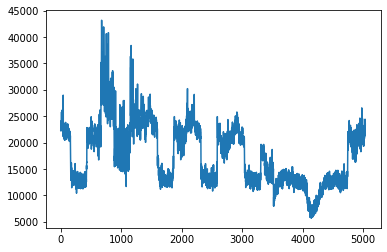

In [ ]:
plt.plot(semaine_extraite)

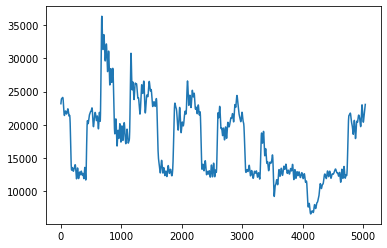

In [ ]:
plt.plot(recons_sem_2)

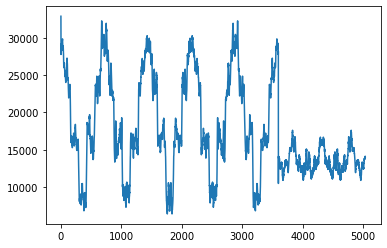

In [ ]:
plt.plot(recons_sem_1)

In [ ]:
Q=round(Nombre_lon/(720*7))
R=Nombre_lon%(720*7)
recons_sig_1=recons_sem_1*Q + recons_sem_1[0:R+2]
recons_sig_2=recons_sem_2*Q + recons_sem_2[0:R+2]

In [ ]:
new_df_maxi_loc=cp.deepcopy(U)
new_df_spectrum_take=cp.deepcopy(U)

In [ ]:
for j in range(0,Nombre_lon):
  if np.isnan(new_df_maxi_loc.iloc[j,Num_mes])==True:
    new_df_maxi_loc.iloc[j,Num_mes]=recons_sig_1[j]
  if np.isnan(new_df_spectrum_take.iloc[j,Num_mes])==True:
    new_df_spectrum_take.iloc[j,Num_mes]=recons_sig_2[j]

0

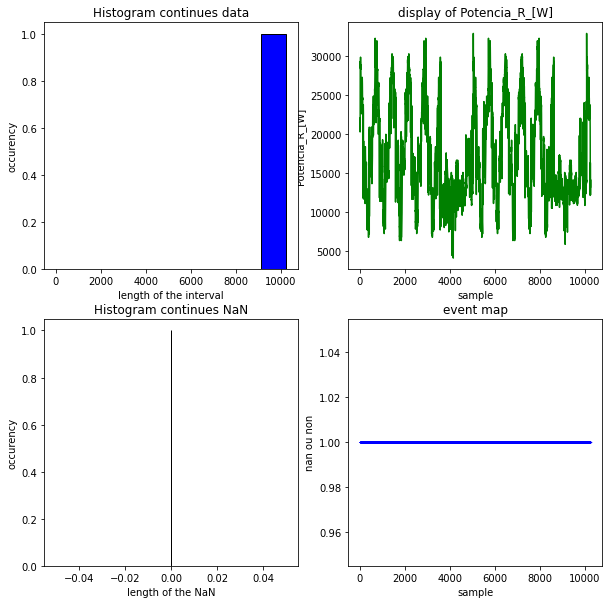

In [ ]:
trace_histo_longueur_donnee(new_df_maxi_loc,10,dates1,mesure[Num_mes])

0

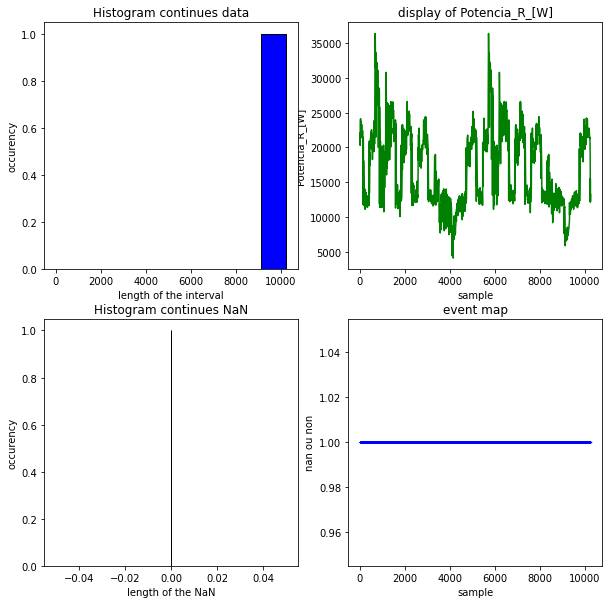

In [ ]:
trace_histo_longueur_donnee(new_df_spectrum_take,10,dates1,mesure[Num_mes])

In [ ]:
new_df_maxi_loc.isnull().sum()
p=list(new_df_maxi_loc.iloc[:,Num_mes])
p2=list(df_energie_rempli.iloc[:,Num_mes])
rmse=np.sqrt(mean_squared_error(p,p2))
mape=mean_absolute_percentage_error(p,p2)
print(rmse)
print(mape)

5790.1760478516135
0.29295173437387073


In [ ]:
new_df_spectrum_take.isnull().sum()
p=list(new_df_spectrum_take.iloc[:,Num_mes])
p2=list(df_energie_rempli.iloc[:,Num_mes])
rmse=np.sqrt(mean_squared_error(p,p2))
mape=mean_absolute_percentage_error(p,p2)
print(rmse)
print(mape)

3978.5211207280486
0.1543016176876869


In [ ]:
plot_final=cp.deepcopy(new_df_maxi_loc.loc[:,mesure[Num_mes]])
plot_final=plot_final.to_frame()
plot_final.insert(1,"power",np.array(df_energie_rempli.loc[:,mesure[Num_mes]]))

In [ ]:
fig = px.line(plot_final, x=plot_final.index, y=plot_final.loc[:,mesure[Num_mes]:"power"].columns, title='Plot of correction')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()

In [ ]:
plot_final=cp.deepcopy(new_df_spectrum_take.loc[:,mesure[Num_mes]])
plot_final=plot_final.to_frame()
plot_final.insert(1,"power",np.array(df_energie_rempli.loc[:,mesure[Num_mes]]))

In [ ]:
fig = px.line(plot_final, x=plot_final.index, y=plot_final.loc[:,mesure[Num_mes]:"power"].columns, title='Plot of correction')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()

We use here the moving average method to calculate the holes.(note that we had a sigma2 mesure to make the value change if the sigma2 is two big i.e if the signal change very abruptly of value).

In [ ]:
new_df_mov_av=cp.deepcopy(U)

In [ ]:
X=list(new_df_mov_av.loc[:,mesure[Num_mes]])
N=len(X)
taille_chariot=3
sigma2_max=100000
for j in range(taille_chariot,N):
  if(np.isnan(X[j])==True):
    sigma2=statistics.variance(X[j-taille_chariot:j])
    if sigma2> sigma2_max:
      X[j]=X[j-1]
    else:
      X[j]=statistics.mean(X[j-taille_chariot:j]) 
new_df_mov_av.iloc[:,Num_mes]=X


0

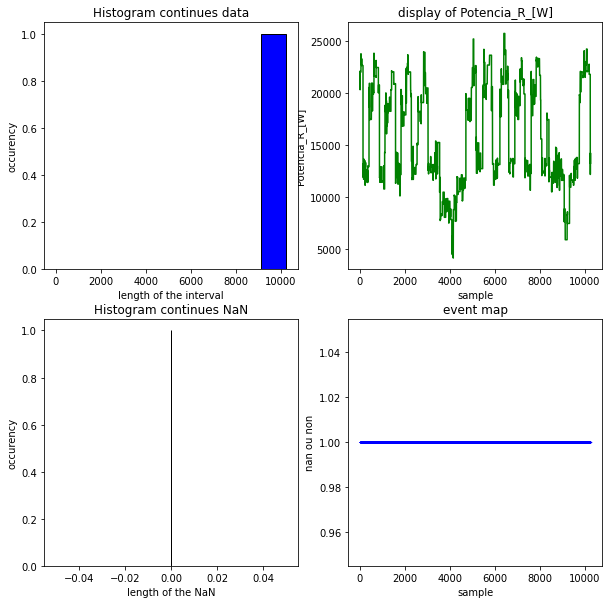

In [ ]:
trace_histo_longueur_donnee(new_df_mov_av,10,dates1,mesure[Num_mes])

In [ ]:
plot_final=cp.deepcopy(new_df_mov_av.loc[:,mesure[Num_mes]])
plot_final=plot_final.to_frame()
plot_final.insert(1,"power",np.array(df_energie_rempli.loc[:,mesure[Num_mes]]))

In [ ]:
fig = px.line(plot_final, x=plot_final.index, y=plot_final.loc[:,mesure[Num_mes]:"power"].columns, title='Plot of correction')
fig.update_xaxes(rangeslider_visible=True,
        rangeselector=dict(
        buttons=list([
          dict(count=1, label="1d", step="day", stepmode="backward"),
          dict(count=7, label="1w", step="day", stepmode="backward"),
          dict(count=14, label="2w", step="day", stepmode="todate"),
          dict(count=1, label="1m", step="month", stepmode="backward"),
          dict(step="all")
        ]))
)
fig.update_layout(    autosize=False,
width=1000,
height=500)
fig.show()